# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from gwpy.timeseries import TimeSeries
import astropy.units as u

In [3]:
data = TimeSeries.read('L-L1_G429267_llhoft-1376089749.0-14.gwf', 'L1:GDS-CALIB_STRAIN_CLEAN')
times_list = [float(i/u.s) for i in data.times]
# has 14s of data sampled at 16K

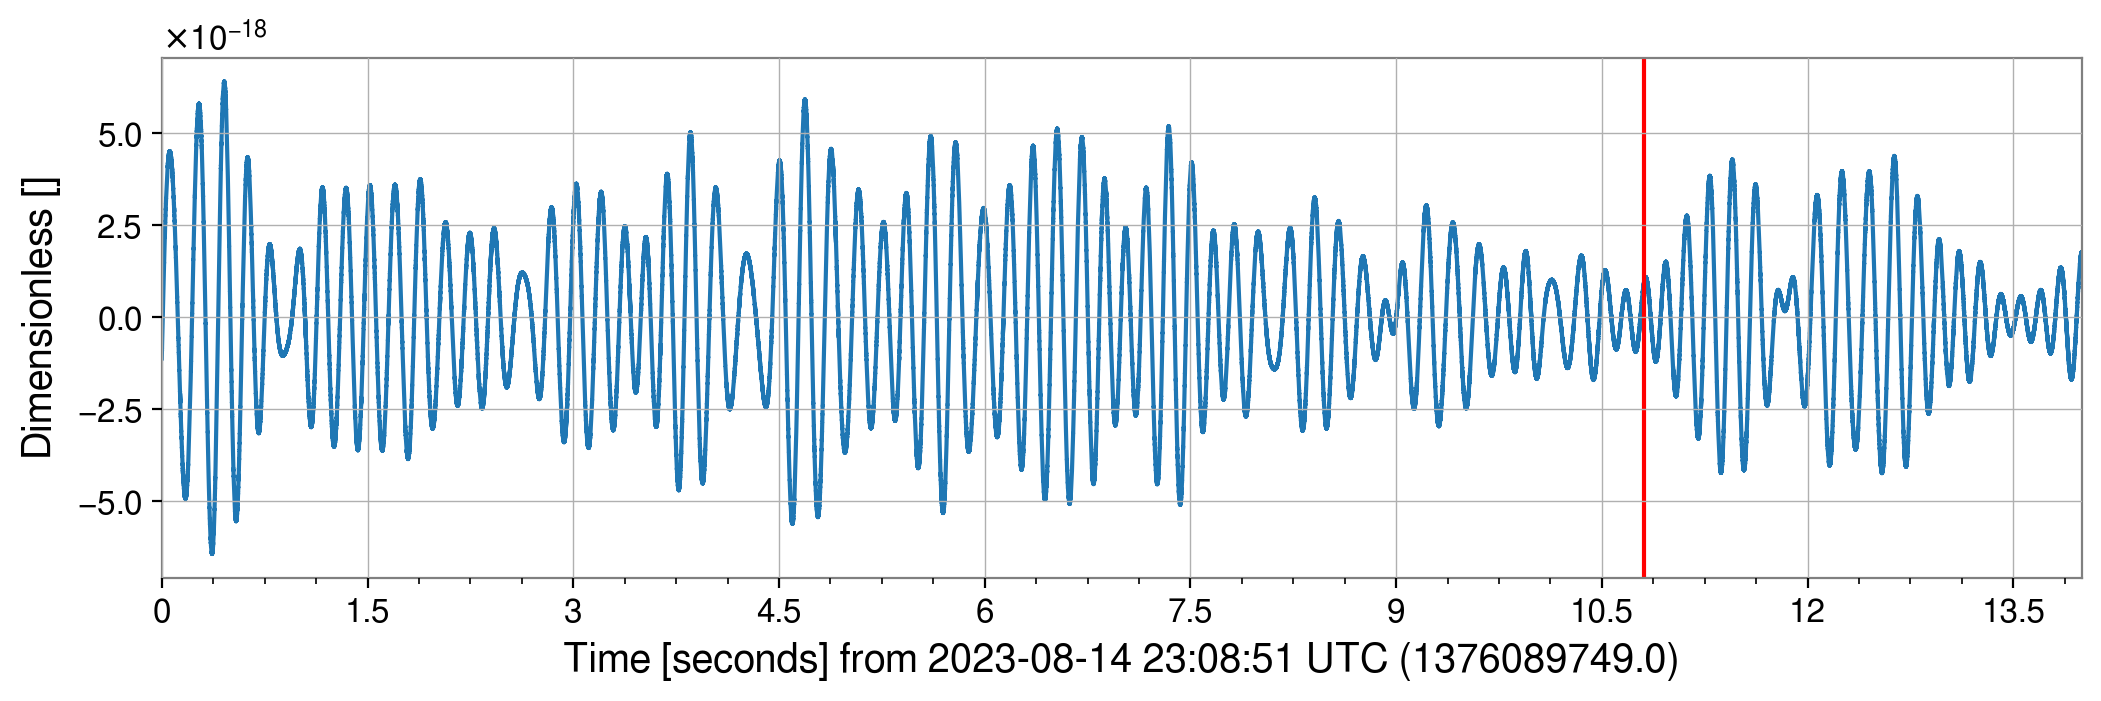

In [4]:
t_ref = 1376089759.81
data.plot()
pl.axvline(t_ref, c = 'r')

(1e-24, 1e-19)

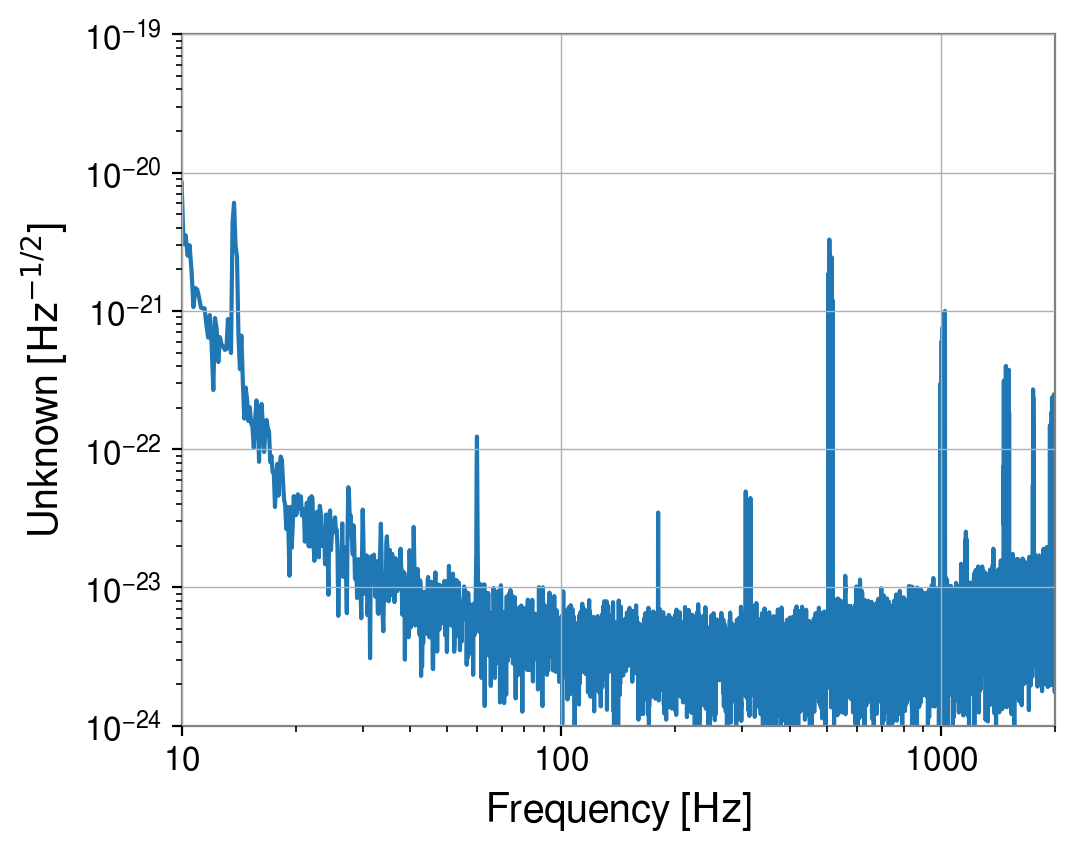

In [5]:
data.asd(fftlength = 8).plot()
pl.xlim(10,2000)
pl.ylim(1e-24, 1e-19)

(1376089759.61, 1376089759.9099998)

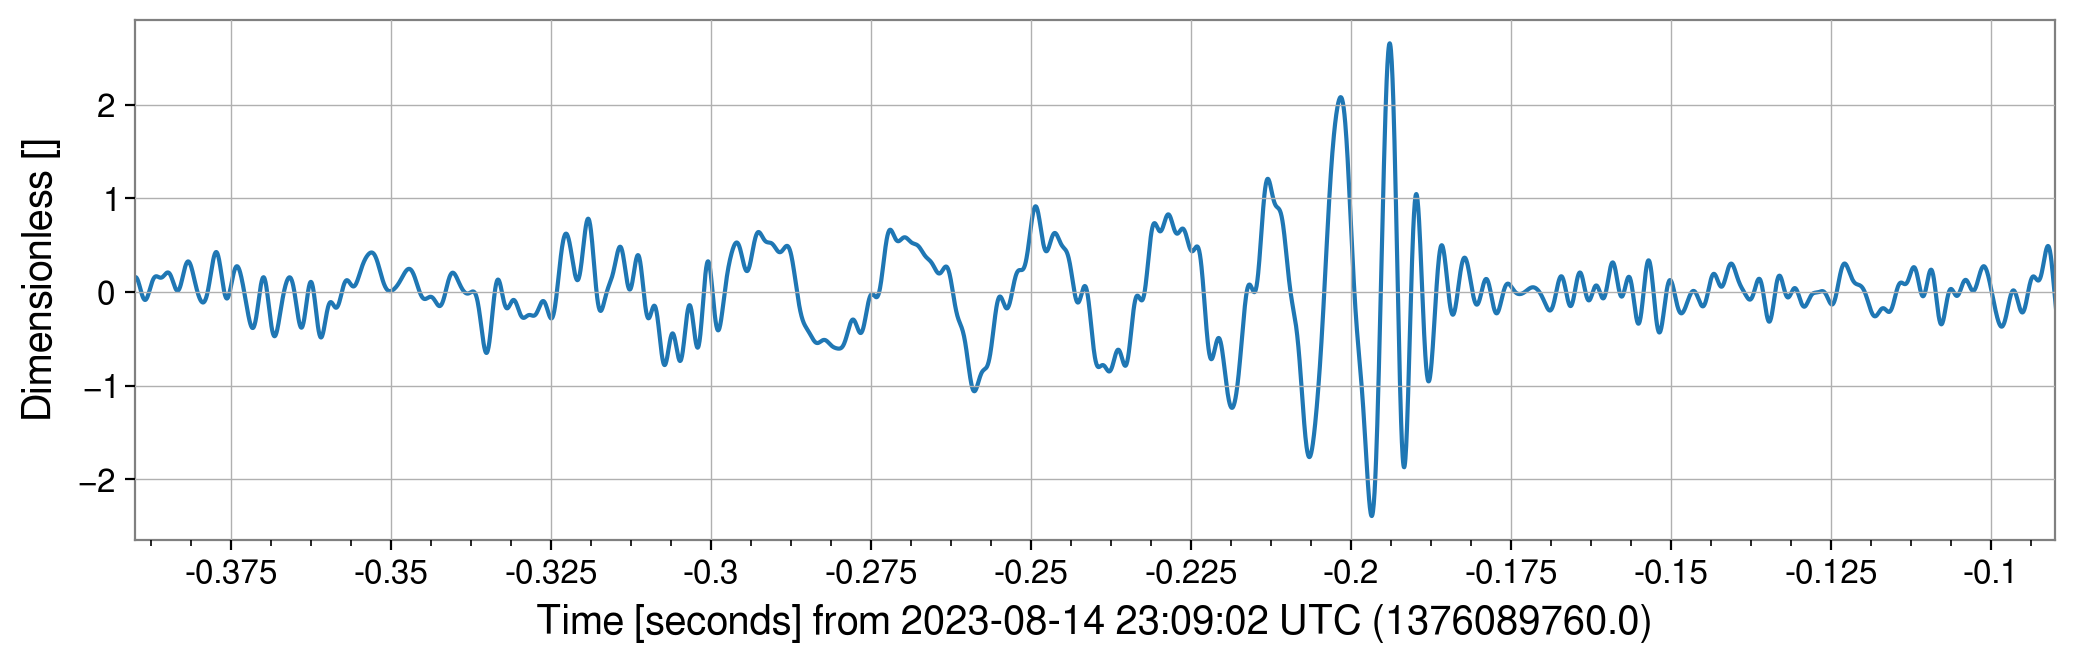

In [6]:
# -- Whiten and bandpass data
white_data = data.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
pl.xlim(t_ref-0.2, t_ref+0.1)

In [7]:
t_0 = float(bp_data.times[np.argmax(bp_data.value)]/u.s)

In [8]:
t_0

1376089759.8060913

Download data

Set some parameters of GW150914

In [51]:
IMR = [63.06, 0.68]
mass_unit = qnm_filter.Filter.mass_unit(IMR[0]) 
time_offset = 0 # in units of mass

input = dict(model_list = [(2,2,0,'p'),(2,2,1,'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = t_0+time_offset*mass_unit, #event time from https://gracedb.ligo.org/superevents/S230814ah/view/
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)
output_str = ''
for item in input['model_list']:
    output_str += f"{item[0]}{item[1]}{item[2]}+"
filter_str = output_str.rstrip('+')

fit = qnm_filter.Network(**input)

Load data

In [52]:
fit.original_data['L1'] = qnm_filter.RealData(data.value, index = times_list)

Perform time alignment across detectors

In [53]:
fit.detector_alignment()

Condition data 

In [54]:
fit.condition_data('original_data', trim = 0.05, **input)

Cholesky-decomposition of the covariance matrix 

In [55]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

In [56]:
from copy import deepcopy
fit_new = deepcopy(fit)

## Fixing 220 to IMR

In [57]:
fit.first_index()
fit.add_filter(mass=IMR[0], chi=IMR[1], model_list=[(2,2,1,'p')])
fit.original_data = fit.filtered_data

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [58]:
delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [60]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [61]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

Plot 2d contours

In [62]:
IMR_analysis = [63.06, 0.68, [[1.23], [1.8]], [[0.02], [0.02]]]
cbar_levels = np.linspace(-480, -375, 22, endpoint=True)

Text(0.5, 1.0, 'S230814ah \n $t_{init}$ + 0$M$, filters = 220+221')

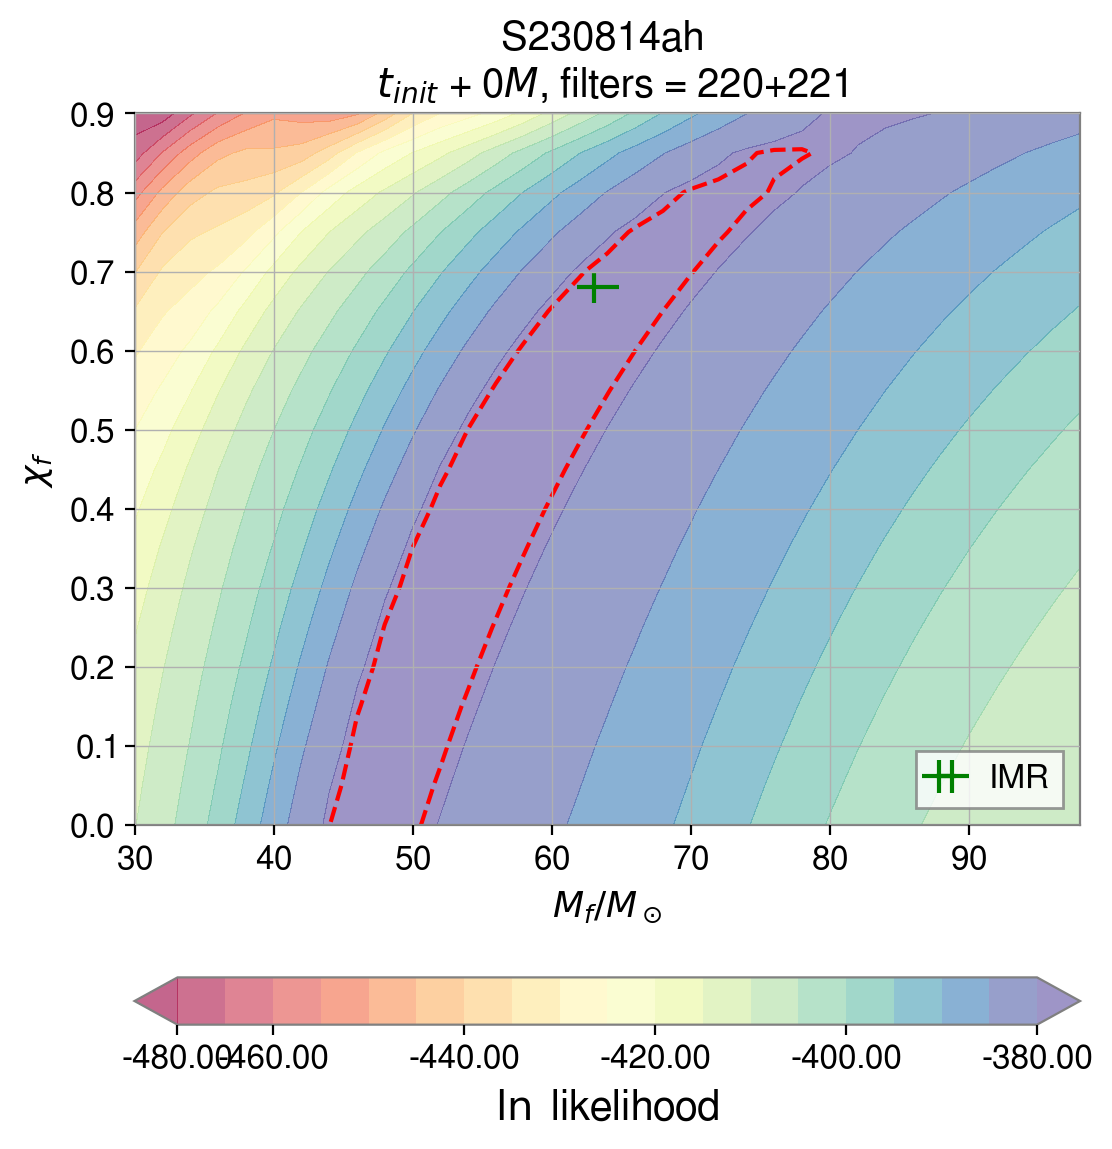

In [63]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, levels = 20, extend = 'both', cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
#ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(cbar_levels[::4])

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend(loc = 'lower right')

ax.set_title('S230814ah \n $t_{init}$ + ' + str(time_offset) +
             r'$M$, filters = ' + filter_str)
# pl.savefig(home_dir+'results/gif_imgs/{}/{}_t={}M.png'.format(filter_str, filter_str, time_offset))

In [21]:
temp = contours.levels

In [22]:
temp

array([-480., -475., -470., -465., -460., -455., -450., -445.,
       -440., -435., -430., -425., -420., -415., -410., -405.,
       -400., -395., -390., -385., -380., -375.])

In [23]:
np.max(likelihood_data)

-377.6757346018192

In [24]:
'results/gif_imgs/{}_t={}M.png'.format(filter_str, time_offset)

'results/gif_imgs/210_t=0M.png'

Text(0.5, 1.0, 'S230814 \n $t_{init}$ + 0$M_\\odot$, filters = 210')

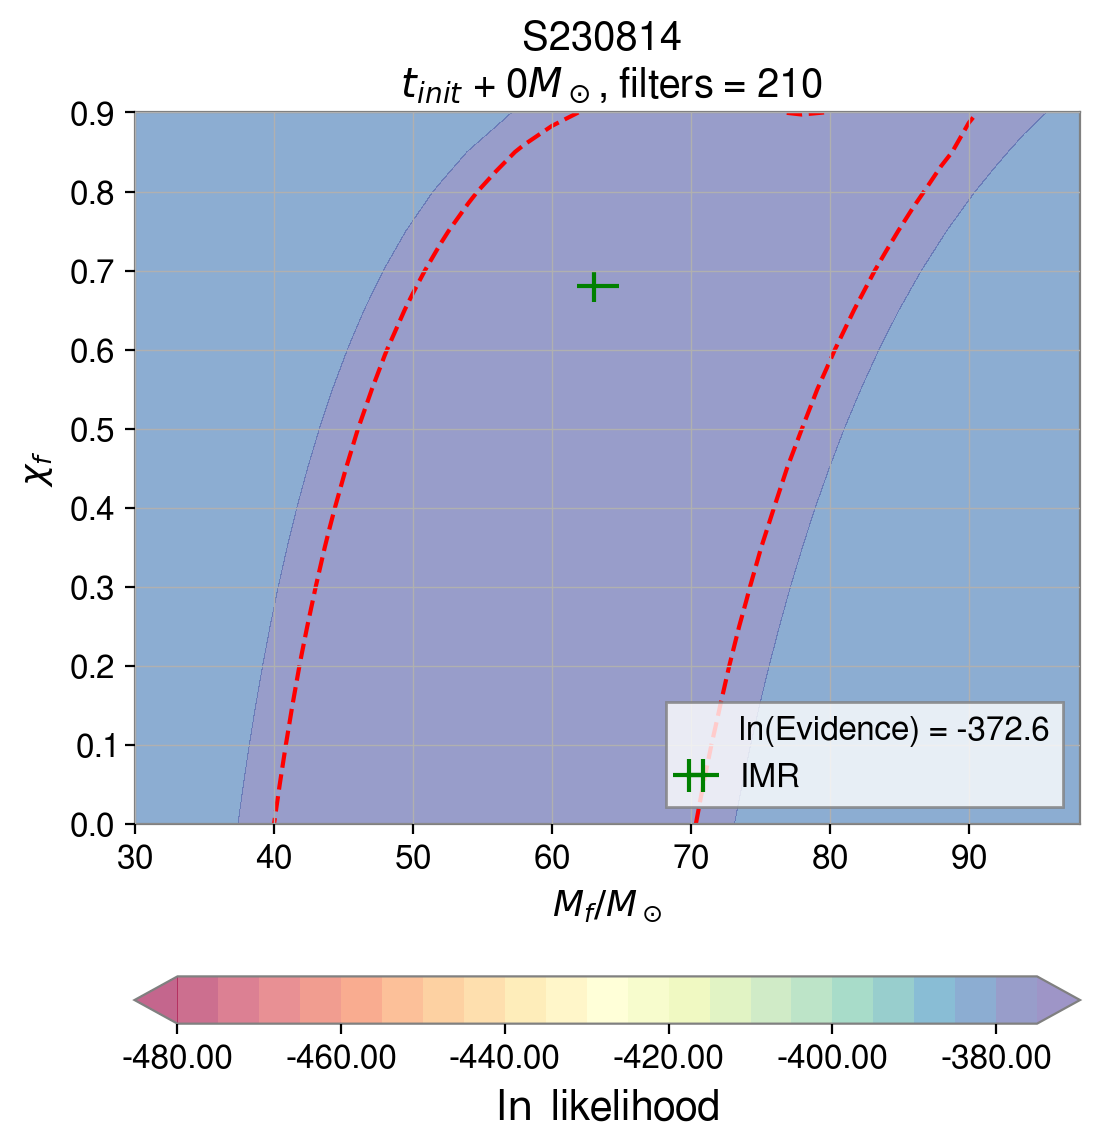

In [25]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, levels = temp, extend = 'both', cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(temp[::4])

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend(loc = 'lower right')

ax.set_title('S230814 \n $t_{init}$ + ' + str(time_offset) +
             r'$M_\odot$, filters = ' + filter_str)
# pl.savefig('./gif_imgs/220+1_t={}M.png'.format(time_offset))